## Dataset and Problem Introduction

In this analysis, we explore predicting fake news using Logistic Regression for the classification of articles.

Data Source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
<br>Reference: https://dataquest.io/

## Data

The data is split into two datasets, containing 44,898 articles in total. The columns include:

* title: Contains the title of each article.
* text: Contains the context of each article.
* subject: Contains the subject of each article.
* date: Contains the date each article was posted in a Month DD, YYYY format.

We do not use the text column for this project.

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

warnings.simplefilter(action='ignore', category=Warning)
pd.options.mode.chained_assignment = None

fake = pd.read_csv("datasets/Fake.csv", usecols=["title", "subject", "date"]).copy()
real = pd.read_csv("datasets/True.csv", usecols=["title", "subject", "date"]).copy()

#labelling the data
fake["label"] = "fake"
real["label"] = "real"

#combining the datasets
news = pd.concat([fake, real], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
print('Label counts:')
print(news.label.value_counts(dropna=False))
news.head()

Label counts:
fake    23481
real    21417
Name: label, dtype: int64


,title,subject,date,label
0,Trump Calls For This Racist Policy To Be Forc...,News,"September 21, 2016",fake
1,Republican ex-defense secretary Cohen backs Hi...,politicsNews,"September 7, 2016",real
2,"TEACHER QUITS JOB After 5th, 6th Grade Muslim ...",politics,"May 9, 2017",fake
3,LAURA INGRAHAM RIPS INTO THE PRESS…Crowd Goes ...,politics,"Jul 21, 2016",fake
4,Germany's Merkel suffers state vote setback as...,worldnews,"October 14, 2017",real


## Preprocessing the data
- Some subject names are written in camel case with others written in snake case and more - replace the column names.
- Some articles have falsely formatted dates and other values for dates are all labelled fake - replace these values with null.

In [2]:
#changing column names
news["subject"] = news["subject"].replace({"politicsNews": "Politics",
                                           "worldnews": "World",
                                           "politics": "Politics",
                                           "News": "All",
                                           "left-news": "Left", 
                                           "Government News": "Government",
                                           "US_News": "US",
                                           "Middle-east": "Middle East"})

#fixing date values
news.loc[news.date.str.extract(r"^((?!\w+ \d+, \d+))*", expand=False).notnull(), "date"] = np.nan

## Visualizing the data for  further insights

In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   subject  44898 non-null  object
 2   date     44853 non-null  object
 3   label    44898 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


Text(0, 0.5, 'Count')

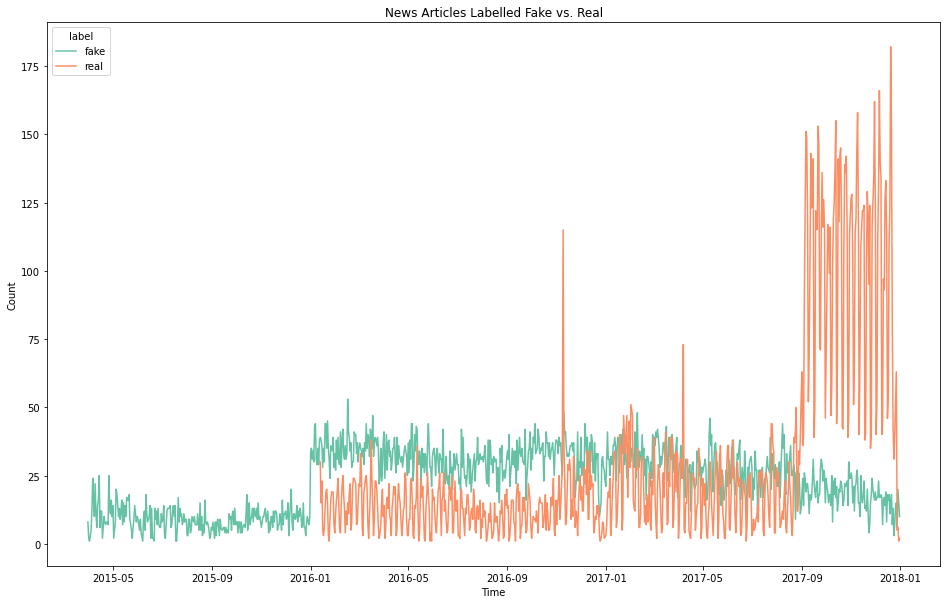

In [4]:
news.date = pd.to_datetime(news.date, errors="coerce")
news_grouped = news[["date", "subject", "label"]].groupby(["date", "label"]).count().reset_index()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="date", y="subject", hue="label", data=news_grouped, palette="Set2", ax=ax)
plt.title("News Articles Labelled Fake vs. Real")
plt.xlabel("Time")
plt.ylabel("Count")

As we can see from the line chart above, we have no real news article data prior to the beginning of 2016. However, even after that, the amount of fake news articles is dominating compared to the amount of real news articles for a period. We also see a sudden increase in number of real news articles in the last quarter of 2016 followed by another unexpected peak in May 2017. Following this, we see a sudden and massive increase in the amount of real article data with a more subtle decrease in number of fake articles over time. 

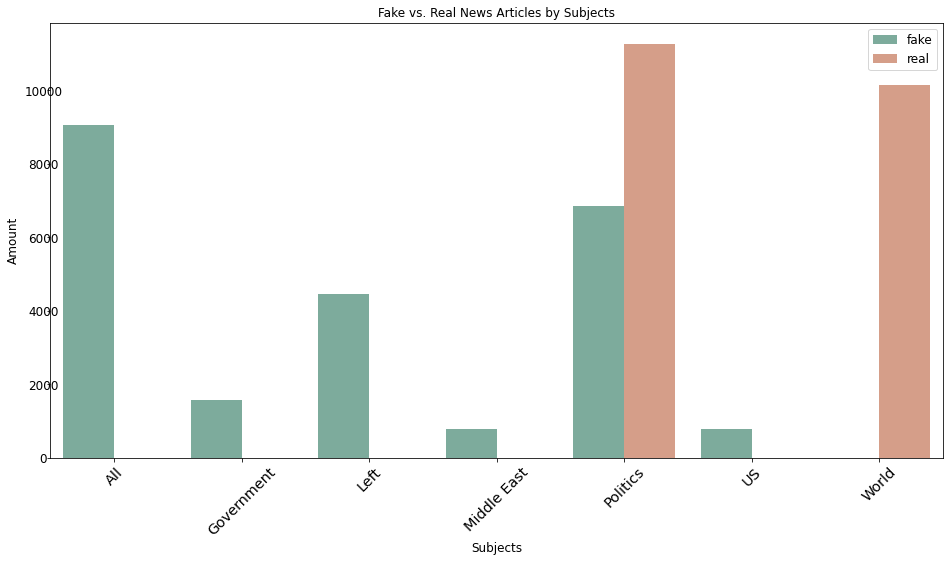

In [5]:
news_group_by_subj_and_label = news.groupby(by=["label", "subject"]).count().reset_index()

fig1, ax1 = plt.subplots(figsize=(16, 8))
sns.barplot(x="subject", y="title", hue="label", data=news_group_by_subj_and_label, palette="Set2", saturation=0.5, ax=ax1)
plt.title("Fake vs. Real News Articles by Subjects")
plt.xticks(rotation=45, horizontalalignment='center', fontweight='light', fontsize='x-large')
plt.yticks(horizontalalignment='center', fontweight='light', fontsize='large')
plt.xlabel("Subjects", fontsize="large")
plt.ylabel("Amount", fontsize="large")
plt.legend(fontsize="large")

As we can see from above, the "real" article group contains articles from "Politics" or "World" as their subjects, while "fake" articles consist of a variety of different subjects. Fake news articles seem to have a tendency to belong into the subject category "All", followed by "Politics", while not showing any interest in the "World" category. Both real and fake articles have many articles in the "Politics" category. 

## Further Preprocessing
- Drop articles that were released before 2016 because there are no real news articles in that period (the data is not representative enough)
- Drop articles from the subjects "Government", "Left", "Middle East" and "US" - The only common subject both fake and real articles have is "Politics" and their frequencies and names also indicate that the "All" subject for fake articles might be the equivalent of the "World" subject for the real news. 

In [6]:
news_clean = news[news.date > dt.datetime(2016,1,1)]
news_clean.date.value_counts().sort_index()
news_clean = news_clean[news_clean.subject.isin(["All", "Politics", "World"])]

## Feature Weighting
We use words in the article titles as the model features and we assign weights to these words using their term-frequencies. 

In [7]:
training_data, testing_data = train_test_split(news_clean, random_state=1) #seed for reproducibility

Y_train = training_data["label"].values
Y_test = testing_data["label"].values

def word_counter(data, column, training_set, testing_set):

    cv = CountVectorizer(binary=False, max_df=0.95)
    cv.fit_transform(training_data[column].values)
    
    train_feature_set = cv.transform(training_data[column].values)
    test_feature_set = cv.transform(testing_data[column].values)
    
    return train_feature_set, test_feature_set, cv

X_train, X_test, feature_transformer = word_counter(news_clean, "title", training_data, testing_data)

## Training the model

In [8]:
classifier = LogisticRegression(solver="newton-cg", C=5, penalty="l2", multi_class="multinomial", max_iter=1000)
model = classifier.fit(X_train, Y_train)

## Prediction & Accuracy
Accuracy is measured using the formula below:

\begin{equation}
\text{Accuracy} = \frac{\text{number of correctly classified articles}}{\text{total number of classified articles}}
\end{equation}

In [9]:
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions, normalize=True)
print("Our model has {}% prediction accuracy.".format(round(accuracy, 2) * 100))

Our model has 96.0% prediction accuracy.


Using Multinomial Logistic Regression for classification, our model successfully classified 96% of the testing data.